In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.patches as mpatches

In [145]:
melbourneDataset = pd.read_csv("Melbourne_housing_FULL.csv")
print(melbourneDataset.info())
print(melbourneDataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

## 1. Prepare data

In [146]:
# Variables
melbourneDataset = melbourneDataset[["Price","Rooms","Distance","Bathroom","Car","Landsize","BuildingArea","YearBuilt",
                                     "Lattitude", "Longtitude","Propertycount", "Suburb", "Address", "Type", "Method",
                                     "SellerG","Date", "Regionname"]]

In [147]:
#Drop data and Outliers
melbourneDataset = melbourneDataset[melbourneDataset['BuildingArea']>0]
melbourneDataset = melbourneDataset[melbourneDataset['YearBuilt']> 1835]
melbourneDataset.dropna(inplace = True)

#Encode objects
cols=('Suburb', 'Address', 'Type', 'Method', 'SellerG',
       'Date', 'Regionname', 'Propertycount')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(melbourneDataset[c].values)) 
    melbourneDataset[c] = lbl.transform(list(melbourneDataset[c].values))
    
melbourneDataset['Price'] = np.log1p(melbourneDataset['Price'])
melbourneDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8840 entries, 2 to 34856
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          8840 non-null   float64
 1   Rooms          8840 non-null   int64  
 2   Distance       8840 non-null   float64
 3   Bathroom       8840 non-null   float64
 4   Car            8840 non-null   float64
 5   Landsize       8840 non-null   float64
 6   BuildingArea   8840 non-null   float64
 7   YearBuilt      8840 non-null   float64
 8   Lattitude      8840 non-null   float64
 9   Longtitude     8840 non-null   float64
 10  Propertycount  8840 non-null   int64  
 11  Suburb         8840 non-null   int32  
 12  Address        8840 non-null   int32  
 13  Type           8840 non-null   int32  
 14  Method         8840 non-null   int32  
 15  SellerG        8840 non-null   int32  
 16  Date           8840 non-null   int32  
 17  Regionname     8840 non-null   int32  
dtypes: floa

In [148]:
#Scale and split data
target = melbourneDataset["Price"]
variables = melbourneDataset.drop("Price", 1)
scaler = MinMaxScaler()
x = scaler.fit_transform(variables)
x_train, x_test, y_train, y_test = train_test_split(x , target , test_size = 0.3 , random_state = 100)

C:\Users\elpha\AppData\Local\Temp\ipykernel_3252\1710414915.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  variables = melbourneDataset.drop("Price", 1)


In [149]:
summary = pd.DataFrame(columns=['Model', 'R^2', 'RMSE', 'MAE','MSE'])
#Function to append data to summary
def add_to_summary(model, y_test, y_pred):
    global summary
    r= round(metrics.explained_variance_score(y_test,y_pred), 4)
    rmse =  round(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),4)
    mae = round(metrics.mean_absolute_error(y_test,y_pred),4)
    mse =  round(metrics.mean_squared_error(y_test,y_pred),4)
    
    summary = summary.append(
                             {'Model': model,
                              'R^2': r,
                              'RMSE': rmse,
                              'MAE': mae,
                              'MSE': mse
                             } ,ignore_index=True)


<AxesSubplot:>

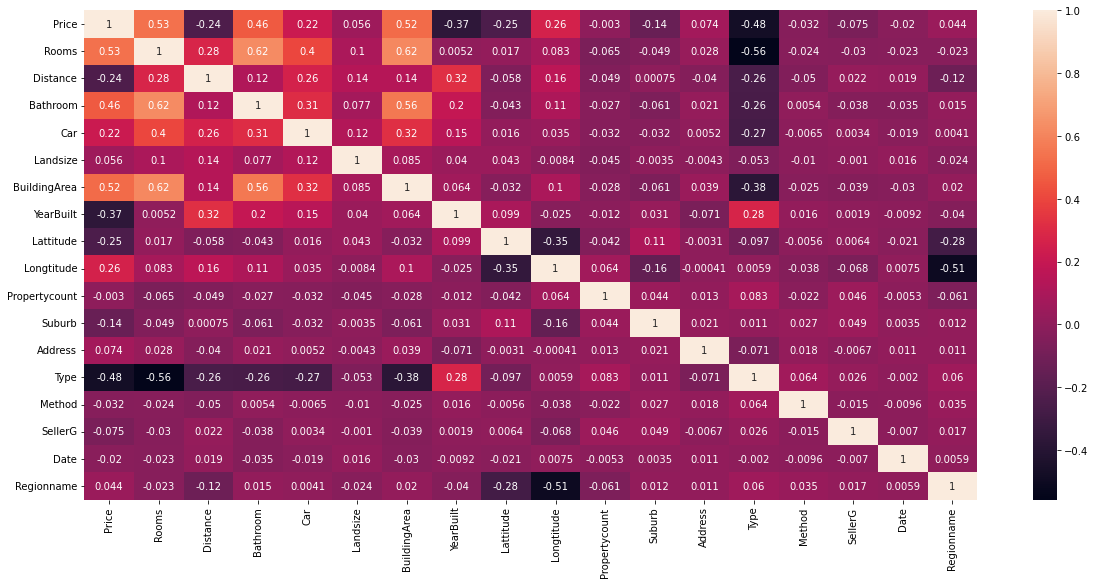

In [150]:
corr = melbourneDataset.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot=True)

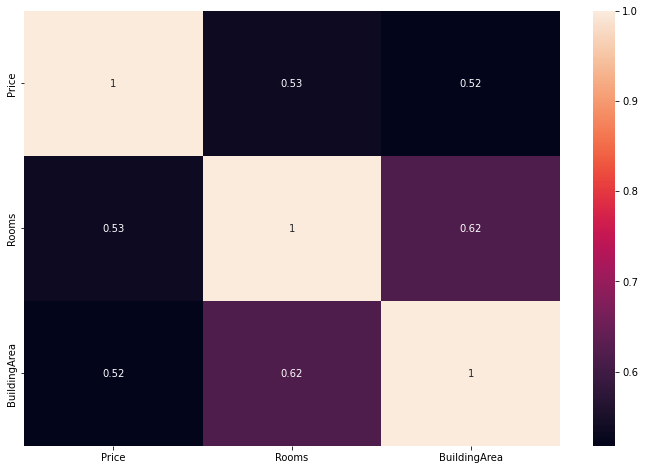

In [151]:
top_feature = corr.index[abs(corr['Price']>0.5)]
plt.subplots(figsize=(12, 8))
top_corr = melbourneDataset[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

## 2. Models

### 2.1 Linear Regression

In [152]:
lr = LinearRegression().fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
add_to_summary("Linear Regression", y_test, y_pred_lr)
print('R^2: %0.4f' %metrics.explained_variance_score(y_test,y_pred_lr))
print('RMSE:%0.4f'%np.sqrt(metrics.mean_squared_error(y_test,y_pred_lr)))
print('MAE: %0.4f'%metrics.mean_absolute_error(y_test,y_pred_lr))
print('MSE:%0.4f'%metrics.mean_squared_error(y_test,y_pred_lr))

R^2: 0.7411
RMSE:0.2737
MAE: 0.2051
MSE:0.0749


C:\Users\elpha\AppData\Local\Temp\ipykernel_3252\3940317719.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(


### 2.2 Support Vector Machine: SRV

In [154]:
svr = SVR().fit(x_train, y_train)
y_pred_svr = svr.predict(x_test)
add_to_summary("SVR", y_test, y_pred_svr)
print('R^2: %0.4f' %metrics.explained_variance_score(y_test,y_pred_svr))
print('RMSE:%0.4f'%np.sqrt(metrics.mean_squared_error(y_test,y_pred_svr)))
print('MAE: %0.4f'%metrics.mean_absolute_error(y_test,y_pred_svr))
print('MSE:%0.4f'%metrics.mean_squared_error(y_test,y_pred_svr))

R^2: 0.8170
RMSE:0.2301
MAE: 0.1671
MSE:0.0530


C:\Users\elpha\AppData\Local\Temp\ipykernel_3252\3940317719.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(


### 2.3 Gradient Boosting Regressor

In [155]:
bestScore = 0
bestLr = 0
best_y_predGBR = 0
for lr in range(1, 100, 2):
    lr = lr/100
    gbr = GradientBoostingRegressor(learning_rate = lr).fit(x_train, y_train)
    y_pred = gbr.predict(x_test)
    if metrics.explained_variance_score(y_test,y_pred) > bestScore:
        bestScore = metrics.explained_variance_score(y_test,y_pred)
        bestLr = lr
        best_y_predGBR = y_pred
add_to_summary("Gradient Boosting Regressor", y_test, best_y_predGBR)

print('Learning rate: %0.2f' %bestLr)
print('R^2: %0.4f' %metrics.explained_variance_score(y_test,best_y_predGBR))
print('RMSE:%0.4f'%np.sqrt(metrics.mean_squared_error(y_test,best_y_predGBR)))
print('MAE: %0.4f'%metrics.mean_absolute_error(y_test,best_y_predGBR))
print('MSE:%0.4f'%metrics.mean_squared_error(y_test,best_y_predGBR))

Learning rate: 0.31
R^2: 0.8787
RMSE:0.1874
MAE: 0.1328
MSE:0.0351


C:\Users\elpha\AppData\Local\Temp\ipykernel_3252\3940317719.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(


### 2.4 Random Forest

In [157]:
bestScore = 0
bestN = 0
best_y_predRFG = 0
for n in range(100, 200):
    rfr = RandomForestRegressor(n_estimators=n, n_jobs=-1).fit(x_train, y_train)
    y_pred = rfr.predict(x_test)
    if metrics.explained_variance_score(y_test,y_pred) > bestScore:
        bestScore = metrics.explained_variance_score(y_test,y_pred)
        bestN = n
        best_y_predRFG = y_pred
add_to_summary("Random Forest", y_test, best_y_predRFG)

print('Trees: %f0' %bestN)
print('R^2: %0.4f' %metrics.explained_variance_score(y_test,best_y_predRFG))
print('RMSE:%0.4f'%np.sqrt(metrics.mean_squared_error(y_test,best_y_predRFG)))
print('MAE: %0.4f'%metrics.mean_absolute_error(y_test,best_y_predRFG))
print('MSE:%0.4f'%metrics.mean_squared_error(y_test,best_y_predRFG))

Trees: 149.0000000
R^2: 0.8738
RMSE:0.1911
MAE: 0.1350
MSE:0.0365


C:\Users\elpha\AppData\Local\Temp\ipykernel_3252\3940317719.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(


### 2.5 Neural Network: Keras Regression

In [159]:
model = Sequential()
for layer in range(6):
    model.add(Dense(10,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')
model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=128,epochs=400)
model.summary()

Epoch 1/400
49/49 [==============================] - 1s 3ms/step - loss: 182.4307 - val_loss: 167.4079
Epoch 2/400
49/49 [==============================] - 0s 1ms/step - loss: 104.7100 - val_loss: 8.3933
Epoch 3/400
49/49 [==============================] - 0s 1ms/step - loss: 4.9656 - val_loss: 3.8998
Epoch 4/400
49/49 [==============================] - 0s 1ms/step - loss: 3.5727 - val_loss: 3.4949
Epoch 5/400
49/49 [==============================] - 0s 1ms/step - loss: 3.1953 - val_loss: 3.1491
Epoch 6/400
49/49 [==============================] - 0s 1ms/step - loss: 2.8852 - val_loss: 2.8494
Epoch 7/400
49/49 [==============================] - 0s 1ms/step - loss: 2.6082 - val_loss: 2.5844
Epoch 8/400
49/49 [==============================] - 0s 1ms/step - loss: 2.3570 - val_loss: 2.3233
Epoch 9/400
49/49 [==============================] - 0s 1ms/step - loss: 2.0958 - val_loss: 2.0372
Epoch 10/400
49/49 [==============================] - 0s 1ms/step - loss: 1.7763 - val_loss: 1.6422
Epo

Epoch 83/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0742 - val_loss: 0.0729
Epoch 84/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0752 - val_loss: 0.0740
Epoch 85/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0725
Epoch 86/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0747 - val_loss: 0.0777
Epoch 87/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0764 - val_loss: 0.0726
Epoch 88/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0733 - val_loss: 0.0762
Epoch 89/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0727
Epoch 90/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0728 - val_loss: 0.0733
Epoch 91/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0761 - val_loss: 0.0722
Epoch 92/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0734 - val_loss: 0.0726


49/49 [==============================] - 0s 1ms/step - loss: 0.0713 - val_loss: 0.0715
Epoch 165/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0701
Epoch 166/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0706
Epoch 167/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0802
Epoch 168/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0727 - val_loss: 0.0695
Epoch 169/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.0706
Epoch 170/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0699 - val_loss: 0.0698
Epoch 171/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0705
Epoch 172/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0692
Epoch 173/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0732
Epoc

49/49 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0684
Epoch 246/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0723
Epoch 247/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0658
Epoch 248/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0722
Epoch 249/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0698 - val_loss: 0.0685
Epoch 250/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0721
Epoch 251/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0653
Epoch 252/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0676
Epoch 253/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0650
Epoch 254/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0724
Epoc

49/49 [==============================] - 0s 1ms/step - loss: 0.0572 - val_loss: 0.0589
Epoch 327/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0575
Epoch 328/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0557 - val_loss: 0.0574
Epoch 329/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0556 - val_loss: 0.0580
Epoch 330/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0557 - val_loss: 0.0694
Epoch 331/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0793
Epoch 332/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0624
Epoch 333/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0556 - val_loss: 0.0606
Epoch 334/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0544 - val_loss: 0.0594
Epoch 335/400
49/49 [==============================] - 0s 1ms/step - loss: 0.0549 - val_loss: 0.0580
Epoc

                                                                 
 dense_39 (Dense)            (None, 10)                110       
                                                                 
 dense_40 (Dense)            (None, 10)                110       
                                                                 
 dense_41 (Dense)            (None, 1)                 11        
                                                                 
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________


In [160]:
y_pred = model.predict(x_test)
add_to_summary("Neural Network: Keras Regression", y_test, y_pred)

print('VarScore: %0.4f' %metrics.explained_variance_score(y_test,y_pred))
print('R^2: %0.4f' %metrics.explained_variance_score(y_test,best_y_predRFG))
print('RMSE:%0.4f'%np.sqrt(metrics.mean_squared_error(y_test,best_y_predRFG)))
print('MAE: %0.4f'%metrics.mean_absolute_error(y_test,best_y_predRFG))
print('MSE:%0.4f'%metrics.mean_squared_error(y_test,best_y_predRFG))

83/83 [==============================] - 0s 481us/step
VarScore: 0.8071
R^2: 0.8738
RMSE:0.1911
MAE: 0.1350
MSE:0.0365


C:\Users\elpha\AppData\Local\Temp\ipykernel_3252\3940317719.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(


In [162]:
print(summary)


                              Model     R^2    RMSE     MAE     MSE
0                 Linear Regression  0.7411  0.2737  0.2051  0.0749
1                               SVR   0.817  0.2301  0.1671   0.053
2       Gradient Boosting Regressor  0.8787  0.1874  0.1328  0.0351
3                     Random Forest  0.8738  0.1911   0.135  0.0365
4  Neural Network: Keras Regression  0.8071  0.2378  0.1736  0.0566


In [163]:
summary['R^2']=summary['R^2'].astype(float)
summary['RMSE']=summary['RMSE'].astype(float)
summary['MAE']=summary['MAE'].astype(float)
summary['MSE  ']=summary['MSE'].astype(float)

summary_dict = summary.to_dict()
x_labels = tuple(summary_dict["Model"].values())
values = {
    'R^2': tuple(summary_dict['R^2'].values()),
    'RMSE': tuple(summary_dict['RMSE'].values()),
    'MAE': tuple(summary_dict['MAE'].values()),
    'MSE': tuple(summary_dict['MSE'].values())
}


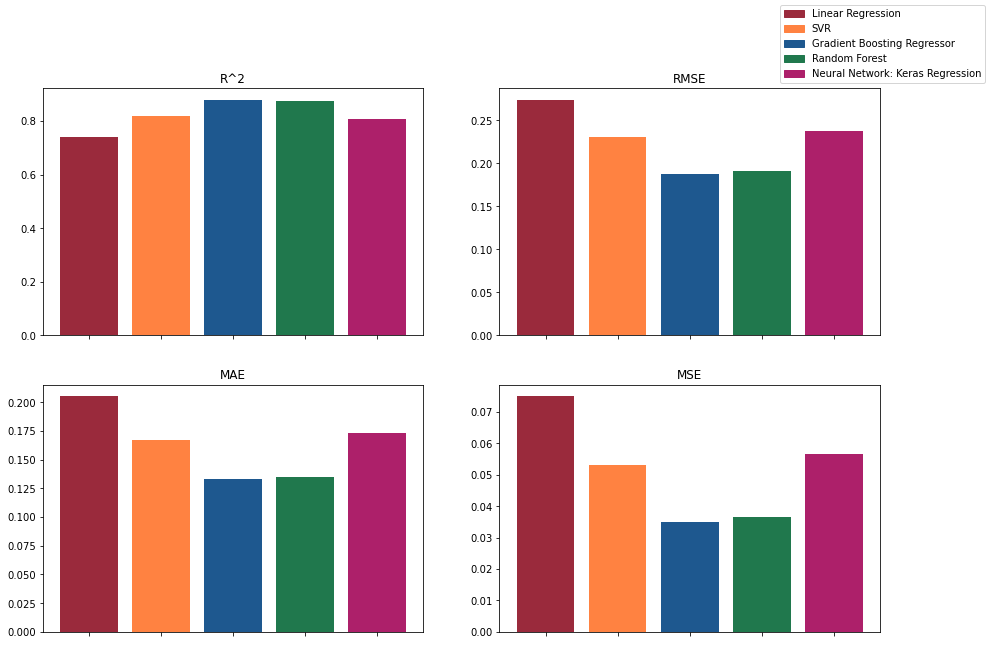

In [164]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
color=("#9a2a3c", "#ff8241", '#1e588f', "#20784d", '#ad206a')
axs[0, 0].bar(x_labels, values['R^2'], color=color,tick_label="")
axs[0, 0].set_title('R^2')
axs[0, 1].bar(x_labels, values['RMSE'], color=color,tick_label="")
axs[0, 1].set_title('RMSE')
axs[1, 0].bar(x_labels, values['MAE'], color=color,tick_label="")
axs[1, 0].set_title('MAE')
axs[1, 1].bar(x_labels, values['MSE'], color=color,tick_label="")
axs[1, 1].set_title('MSE')
h = []
handles, labels = plt.gca().get_legend_handles_labels()
for index in range(len(x_labels)):
    h.append(mpatches.Patch(color=color[index], label=x_labels[index]))
handles.extend(h)
fig.legend(handles=handles, loc ='upper right')

